In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(maxresults=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [3]:
import operator
from typing import Annotated, TypedDict

from langchain_core.messages import AnyMessage


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver

mmemory = SqliteSaver.from_conn_string(":memory:")

In [5]:
from langgraph.graph import StateGraph, END


class Agent:
    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    @classmethod
    def add_method(cls, func):
        setattr(cls, func.__name__, func)

In [6]:
from langchain_core.messages import SystemMessage


@Agent.add_method
def call_openai(self, state: AgentState):
    messages = state["messages"]
    if self.system:
        messages = [SystemMessage(content=self.system)] + messages
    message = self.model.invoke(messages)
    return {"messages": [message]}

In [7]:
@Agent.add_method
def exists_action(self, state: AgentState):
    result = state["messages"][-1]
    return len(result.tool_calls) > 0

In [8]:
from langchain_core.messages import ToolMessage


@Agent.add_method
def take_action(self, state: AgentState):
    tool_calls = state["messages"][-1].tool_calls
    results = []

    for t in tool_calls:
        print(f"Calling: {t}")
        if not t["name"] in self.tools:
            print(f"\n ... bad tool name. {t['name']}")
            result = "bad tool name, retry"
        else:
            result = self.tools[t["name"]].invoke(t["args"])
        results.append(
            ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
        )
    print("Back to the model!")
    return {"messages": results}

In [9]:
from jinja2 import Environment, FileSystemLoader

PROMPTS_PATH = "prompts"
OPENAI_PROMPT = "openai-react-langgraph.jinja"

env = Environment(loader=FileSystemLoader(PROMPTS_PATH))
prompt_template = env.get_template(OPENAI_PROMPT)
prompt = prompt_template.render()
print(prompt)

You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow up question, you are allowed to do that!


In [10]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")
langgraph_bot = Agent(model, tools=[tool], system=prompt, checkpointer=mmemory)

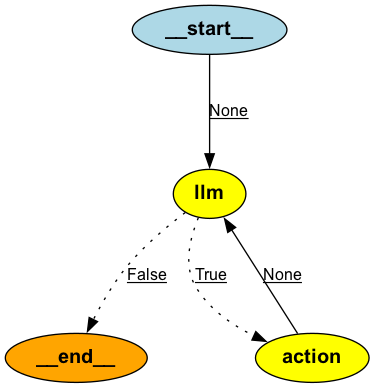

In [11]:
from IPython.display import Image

Image(langgraph_bot.graph.get_graph().draw_png())

In [12]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the weather in sf?")]

In [14]:
thread = {"configurable": {"thread_id": 1}}

In [15]:
for event in langgraph_bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jqQdjJazbYCNvUhMa9zbDXY9', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3140f108-a60f-4f1a-9d88-76c0c7f2ea74-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_jqQdjJazbYCNvUhMa9zbDXY9'}], usage_metadata={'input_tokens': 151, 'output_tokens': 22, 'total_tokens': 173})]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_jqQdjJazbYCNvUhMa9zbDXY9'}
Back to the model!
[ToolMessage(content='[{\'url\': \'https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-

In [16]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "2"}}
for event in langgraph_bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Could you please clarify your question about LA? Are you asking about a specific topic such as weather, events, news, or something else related to Los Angeles?', response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 149, 'total_tokens': 182}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None}, id='run-5eeee01f-e2f3-4d05-a03e-f215881cc831-0', usage_metadata={'input_tokens': 149, 'output_tokens': 33, 'total_tokens': 182})]}


In [17]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in langgraph_bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AJJIXzCO60tcKFyUDnxyMQqw', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1448, 'total_tokens': 1470}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c35ce711-bded-4406-9e3f-7f230920cefc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_AJJIXzCO60tcKFyUDnxyMQqw'}], usage_metadata={'input_tokens': 1448, 'output_tokens': 22, 'total_tokens': 1470})]}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_AJJIXzCO60tcKFyUDnxyMQqw'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.timeanddate.com/weather/usa/l

In [18]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in langgraph_bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Currently, Los Angeles is slightly warmer than San Francisco:\n\n- **Los Angeles**: 63.0°F (17.2°C)\n- **San Francisco**: 62.1°F (16.7°C)\n\nSo, Los Angeles is warmer by 0.9°F (0.5°C).', response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 2780, 'total_tokens': 2844}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None}, id='run-0bde5bb9-48c4-4eb2-9e76-fa8fc1d39469-0', usage_metadata={'input_tokens': 2780, 'output_tokens': 64, 'total_tokens': 2844})]}


In [21]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "3"}}
for event in langgraph_bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Could you please specify what you are referring to when you ask "which one is warmer"? For example, are you comparing the climates of two cities, the temperatures of two objects, or something else?', response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 149, 'total_tokens': 190}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None}, id='run-8cdce38a-2398-44cc-887e-2f8b86d68009-0', usage_metadata={'input_tokens': 149, 'output_tokens': 41, 'total_tokens': 190})]}


In [24]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

memory = AsyncSqliteSaver.from_conn_string(":memory:")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [25]:
messages = [HumanMessage(content="What is the weather in Europe?")]
thread = {"configurable": {"thread_id": "10"}}

In [26]:
async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")

/Users/martinfabbri/Workspace/github/graph-llm-agents/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Europe'}, 'id': 'call_JcI5ZlHlGTdPI6c4Zt7JhY26'}
Back to the model!
The| current| weather| in| Europe| varies| significantly| across| the| continent|.| Here| are| some| key| points| based| on| recent| reports|:

|1|.| **|General| Overview|**|:
|  | -| Europe| is| experiencing| diverse| weather| conditions|.| The| start| of| meteor|ological| summer| |202|4| began| with| wet| and| cool| weather| in| many| parts| of| Europe|,| while| the| southeast| experienced| more| summertime|-like| conditions|.| The| weather| pattern| is| changing|,| leading| to| less| rain| and| triggering| heat|waves| in| south|,| central|,| and| eastern| Europe|.
|   
|2|.| **|Weather| Forecast| Resources|**|:
|  | -| [|Time| and| Date|](|https|://|www|.time|and|date|.com|/weather|/?|continent|=e|urope|)| provides| hour|-by|-hour| and| |2|-week| forecasts|.
|  | -| [|Acc|u|Weather|](|https|://|www|.acc|uwe|ather|.com|/en|/e|urope|